20171216
Time evolution of matrix product mixed state with purification and canonical form

In [1]:
import numpy as np
import math
import time
import scipy
from scipy import linalg
%matplotlib notebook
import matplotlib.pyplot as plt

In [18]:
d=2 # Dimension. For spin 1/2 the dimention = 2
J=1. # XX interaction coefficient
gz=0.5 # Z field strength
gx=0. # X field strength
N=16 # Total number of spins
delta =0.002 # Time step
chi0=10 # Maximum number of singular values
Vc=2.3*J # upper bound of the growth velocity of correlation length. chi=max(chi0,Vc*t)
thr=1e-7; # discarding singular values smaller than thr*largest singular value
t=5
T=int(t/delta)

sx=np.array([[0.,1.],[1.,0.]])
sz=np.array([[1.,0.],[0.,-1.]])
h_int=J*np.kron(sx,sx)
h_single=gz*sz+gx*sx
U_int=linalg.expm(1j*h_int*delta).reshape(d,d,d,d) 
U_single=linalg.expm(1j*h_single*delta).reshape(d,d) # U(si,si')

Mz=list()
Mz.append(np.transpose(np.array([[sz,np.eye(2)]]),(2,3,0,1)))
for i in range(1,N-1):
    temp1=np.array([[np.eye(2),np.zeros((2,2))],[sz,np.eye(2)]])
    temp=np.transpose(temp1,(2,3,0,1))
    Mz.append(temp)
Mz.append(np.transpose(np.array([[np.eye(2)],[sz]]),(2,3,0,1))) # Mz(i,si,si',ai,bi)

Mx=list()
Mx.append(np.transpose(np.array([[sx,np.eye(2)]]),(2,3,0,1)))
for i in range(1,N-1):
    temp1=np.array([[np.eye(2),np.zeros((2,2))],[sx,np.eye(2)]])
    temp=np.transpose(temp1,(2,3,0,1))
    Mx.append(temp)
Mx.append(np.transpose(np.array([[np.eye(2)],[sx]]),(2,3,0,1))) # Mz(i,si,si',ai,bi)

def trace(o):
    L=len(o)
    temp=np.trace(o[0],axis1=0,axis2=1)
    for i in range(1,L):
        temp1=np.trace(o[i],axis1=0,axis2=1)
        temp=np.dot(temp,temp1)
    return temp[0,0]

def exp(o,rho,band):
    L=len(o)
    temp=np.tensordot(o[0],rho[0],axes=([1,0])) # temp(os0,oa0,ob0,rhos0',rhoa0,rhob0)
    temp=np.tensordot(temp,np.conj(rho[0]),axes=(0,0)) # temp(oa0,ob0,rhos0',rhoa0,rhob0,rho*s0',rho*a0,rho*b0)
    temp=np.trace(temp,axis1=2,axis2=5) #temp(oa0,ob0,rhoa0,rhob0,rho*a0,rho*b0)
    temp=np.transpose(temp,(0,2,4,1,3,5)) # temp(oa0,rhoa0,rho*a0,ob0,rhob0,rho*b0)
    for i in range(1,L):
        t1=np.tensordot(rho[i],np.diag(band[i-1]),axes=(2,0)) # t1(rhos0,rhos0',rhob0,rhoa0)
        t1=np.transpose(t1,(0,1,3,2)) # t1(rhos0,rhos0',rhoa0,rhob0)
        temp1=np.tensordot(o[i],t1,axes=([1,0])) # temp(os0,oa0,ob0,rhos0',rhoa0,rhob0)
        temp1=np.tensordot(temp1,np.conj(t1),axes=(0,0)) #temp(oa0,ob0,rhos0',rhoa0,rhob0,rho*s0',rho*a0,rho*b0)
        temp1=np.trace(temp1,axis1=2,axis2=5) #temp(oa0,ob0,rhoa0,rhob0,rho*a0,rho*b0)
        temp=np.tensordot(temp,temp1,axes=([3,4,5],[0,2,4]))
    return temp[0,0,0,0,0,0]

def uni(rho):
    L=len(rho)
    temp=rho[0]
    for i in range(1,L):
        temp=np.tensordot(temp,rho[i],axes=([len(np.shape(temp))-1,2]))
    return np.squeeze(temp)

# returns trace of rho^\dag*rho
def norm(rho,band):
    L=len(rho)
    temp=np.tensordot(np.conj(rho[0]),rho[0],axes=([0,1],[0,1])) # temp(a0',b0',a0,b0) 'belongs to conj.
    temp=np.transpose(temp,(0,2,1,3)) # temp(a0',a0,b0',b0)
    for i in range(1,L):
        t1=np.tensordot(rho[i],np.diag(band[i-1]),axes=(2,0)) # t1(rhos0,rhos0',rhob0,rhoa0)
        t1=np.transpose(t1,(0,1,3,2)) # t1(rhos0,rhos0',rhoa0,rhob0)
        temp1=np.tensordot(np.conj(t1),t1,axes=([0,1],[0,1])) # temp1(ai',bi',ai,bi)
        temp=np.tensordot(temp,temp1,axes=([2,3],[0,2])) # temp(a0',a0,bi',bi)
    return abs(temp[0,0,0,0])

# two-site evolution
def evo2(rho,band,i,U,chi): # U(si,s(i+1),si',s(i+1)')
    #print('rhoi',rho[i].shape)
    #print('bandi-1',band[i-1])
    if i>0:
        A1=np.tensordot(np.diag(band[i-1]),rho[i],axes=(1,2)) # A1(ai,si,si',bi)
        A1=np.transpose(A1,(1,2,0,3))
    else:
        A1=rho[i]
    if i<N-2:
        A2=np.tensordot(rho[i+1],np.diag(band[i+1]),axes=(3,0)) 
    else:
        A2=rho[i+1]
    B=band[i]
    theta=np.tensordot(A1,np.diag(B),axes=(3,0))
#     print('i=',i)
#     print(A1.shape)
#     print(A2.shape)
    theta=np.tensordot(theta,A2,axes=(3,2)) # theta(si,si',ai,s(i+1),s(i+1)',b(i+1))
    dai=A1.shape[2] # dimension of ai
    dbip1=A2.shape[3] # dimension of b(i+1)
    # apply U
    theta=np.tensordot(U,theta,axes=([2,3],[0,3])) # theta(si,s(i+1),si',ai,s(i+1)',b(i+1))
    theta=np.transpose(theta,(0,2,3,1,4,5)) # theta(si,si',ai,s(i+1),s(i+1)',b(i+1))
    sh=theta.shape
    theta=theta.reshape(sh[0]*sh[1]*sh[2],sh[3]*sh[4]*sh[5])
    #print(theta)
    [L,S,R]=scipy.linalg.svd(theta, lapack_driver='gesvd')
    ent=S.shape[0];
    for j in range(1,S.shape[0]):
        if S[j]<thr*S[0]:
            ent=j
            break
    if ent<chi:
        D=S[0:ent]
    else:
        ent=chi
        D=S[0:ent]
    sq=np.sqrt(sum(D**2))
    #print('sq',sq)
    L=L[:,0:ent]#/np.trace(np.dot(np.transpose(L.conj()),L)) # L(si*ai,bi)
    R=R[0:ent,:]#/np.trace(np.dot(np.transpose(R.conj()),R)) # R(a(i+1),s(i+1)*b(i+1))
    
    B1=L.reshape(d,d,dai,ent)
    B2=np.transpose(R.reshape(ent,d,d,dbip1),(1,2,0,3))
    B3=D/sq
    #print('B1',B1.shape)
    if i>0:
        B1=np.tensordot(B1,np.diag(band[i-1]**(-1)),axes=(2,0))
        B1=np.transpose(B1,(0,1,3,2))
    if i<N-2:
        B2=np.tensordot(B2,np.diag(band[i+1]**(-1)),axes=(3,0))

    return B1,B2,B3

#single-site evolution
def evo1(A,U):
    # A(si,si',ai,bi)
    # U(si,si')
    A=np.tensordot(U,A,axes=([1,0])) # A(si,si',ai,bi)
    return A

#get \rho from |\rho^1/2>
def mix(rho):
    L=len(rho)
    Rho=list()
    for i in range(0,L):
        temp=np.tensordot(rho[i],np.conj(rho[i]),axes=[1,1]) #temp(rhos0,rhoa0,rhob0,rho*s0,rho*a0,rho*b0)
        temp=np.transpose(temp,(0,3,1,4,2,5)) #temp(rhos0,rho*s0,rhoa0,rho*a0,rhob0,rho*b0)
        sh=temp.shape
        temp=temp.reshape(sh[0],sh[1],sh[2]*sh[3],sh[4]*sh[5])
        Rho.append(temp)
    return Rho

def hcee(rho):
    L=len(rho)
    LA=int(L/2)
    R=np.trace(rho[LA],axis1=0,axis2=1)
    for i in range(LA,int(L)):
        temp=np.trace(rho[i],axis1=0,axis2=1)
        R=np.dot(R,temp)
    rhoA=list(rho[0:LA])
    rhoA[LA-1]=np.tensordot(rhoA[LA-1],R,axes=([3,0]))
    ta=tuple(range(0,2*LA,2))
    tb=tuple(range(1,2*LA,2))
    temp1=uni(rhoA)
    temp2=np.transpose(temp1,ta+tb)
    MA=temp2.reshape(2**LA,2**LA)
    lam=np.linalg.eigvalsh(MA)
    ee=0
    for i in range(0,np.size(lam)):
        if lam[i]<1e-5:
            break
        ee=ee-lam[i]*np.log(lam[i])
    return ee

# rho0i=np.array([[1.,0.],[0.,1j]])
# rho0=list()
# rho0.append(np.transpose(np.array([[rho0i,np.eye(2)]]),(2,3,0,1)))
# for i in range(1,N-1):
#     temp1=np.array([[np.eye(2),np.zeros((2,2))],[rho0i,np.eye(2)]])
#     temp=np.transpose(temp1,(2,3,0,1))
#     rho0.append(temp)
# rho0.append(np.transpose(np.array([[np.eye(2)],[rho0i]]),(2,3,0,1))) # rho(i,si,si',ai,bi)

beta=0.01
rho0i=linalg.expm(-beta/2*sz).reshape(d,d,1,1) # rho0i(si,si',ai,bi)
rho0=list()
for i in range(0,N):
    rho0.append(rho0i)
    
band0i=np.ones(1)
band0=list()
for i in range(0,N-1):
    band0.append(band0i)

In [19]:
ti=time.process_time()

MzExp=np.zeros(T)
MxExp=np.zeros(T)
#Entropy=np.zeros(T)
#rho=list(Mx)
rho=list(rho0)
band=list(band0)
Norm=norm(rho,band)
for i in range(0,N):
    rho[i]=rho[i]*(1/Norm)**(0.5/N)
MzExp[0]=np.real(exp(Mz,rho,band))
MxExp[0]=np.real(exp(Mx,rho,band))

for p in range(1,T):
    tau=p*delta
    chi=math.ceil(max(chi0,Vc*tau))
    if p%100==0:
        print('t=',tau)
    for i in range(0,N-1,2):
        temp1,temp2,temp3=evo2(rho,band,i,U_int,chi)
        rho[i]=temp1
        rho[i+1]=temp2
        band[i]=temp3
    for i in range(1,N-1,2):
        temp1,temp2,temp3=evo2(rho,band,i,U_int,chi)
        rho[i]=temp1
        rho[i+1]=temp2
        band[i]=temp3
    for i in range(0,N):
        rho[i]=evo1(rho[i],U_single)
    Norm=norm(rho,band)
#     print(Norm)
#     for i in range(0,N):
#         rho[i]=rho[i]*(1/Norm)**(0.5/N)
    MzExp[p]=np.real(exp(Mz,rho,band))
    MxExp[p]=np.real(exp(Mx,rho,band))
    #Entropy[p]=hcee(rho)
tt=time.process_time()-ti

t= 0.2
t= 0.4
t= 0.6
t= 0.8
t= 1.0
t= 1.2
t= 1.4000000000000001
t= 1.6
t= 1.8
t= 2.0
t= 2.2
t= 2.4
t= 2.6
t= 2.8000000000000003
t= 3.0
t= 3.2
t= 3.4
t= 3.6
t= 3.8000000000000003
t= 4.0
t= 4.2
t= 4.4
t= 4.6000000000000005
t= 4.8


In [ ]:
Tcon=int(3/delta)

for p in range(0,Tcon):
    tau=(p+T)*delta
    chi=math.ceil(max(chi0,Vc*tau))
    if p%100==0:
        print('t=',tau)
    for i in range(0,N-1,2):
        temp1,temp2,temp3=evo2(rho,band,i,U_int,chi)
        rho[i]=temp1
        rho[i+1]=temp2
        band[i]=temp3
    for i in range(1,N-1,2):
        temp1,temp2,temp3=evo2(rho,band,i,U_int,chi)
        rho[i]=temp1
        rho[i+1]=temp2
        band[i]=temp3
    for i in range(0,N):
        rho[i]=evo1(rho[i],U_single)
    Norm=norm(rho,band)
    MzExp=np.append(MzExp,np.real(exp(Mz,rho,band)))
    MxExp=np.append(MxExp,np.real(exp(Mz,rho,band)))

T=T+Tcon

t= 15.0
t= 15.5


In [189]:
tlist=np.arange(0,T*delta,delta)
plt.plot(tlist,MzExp/MzExp[0])
plt.show()

<IPython.core.display.Javascript object>


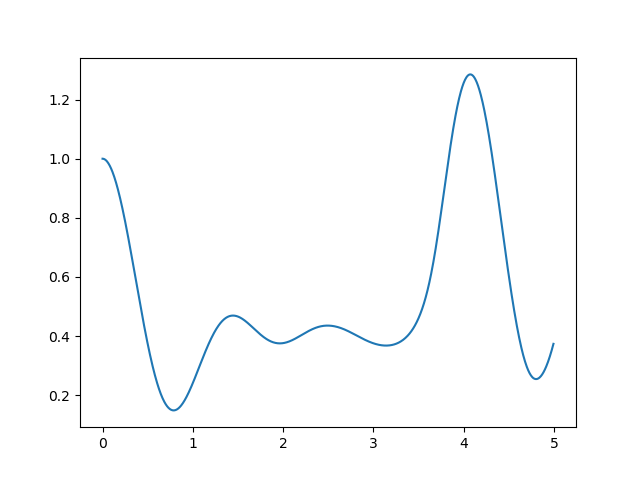

In [17]:
tlist=np.arange(0,T*delta,delta)
plt.plot(tlist,MzExp/MzExp[0])
plt.show()

In [43]:
test=8
hehe=np.tensordot(np.diag(band[test-1]),rho[test],axes=(0,2))
hehe=hehe.transpose(1,2,0,3)
sh=hehe.shape
pp=hehe.reshape(sh[0]*sh[1]*sh[2],sh[3])
np.dot(np.transpose(np.conj(pp)),pp)

array([[  1.00000000e+00 +0.00000000e+00j,
          7.21644966e-16 +1.80411242e-16j,
          1.13090042e-16 -6.71659077e-18j, ...,
          4.50463090e-17 -9.11011728e-18j,
          2.08166817e-16 -2.72351586e-16j,
         -1.41613930e-16 -5.71436352e-17j],
       [  7.21644966e-16 -1.80411242e-16j,
          1.00000000e+00 +0.00000000e+00j,
         -3.87636026e-17 -3.45736879e-17j, ...,
         -2.49387824e-17 -6.04757966e-17j,
         -1.66533454e-16 -1.11022302e-16j,
          1.39838787e-17 -7.02910556e-17j],
       [  1.13090042e-16 +6.71659077e-18j,
         -3.87636026e-17 +3.45736879e-17j,
          1.00000000e+00 +0.00000000e+00j, ...,
          6.78710560e-17 +5.55111512e-17j,
          3.61771193e-16 -7.70760178e-17j,
         -5.55111512e-17 +5.20417043e-17j],
       ..., 
       [  4.50463090e-17 +9.11011728e-18j,
         -2.49387824e-17 +6.04757966e-17j,
          6.78710560e-17 -5.55111512e-17j, ...,
          1.00000000e+00 +0.00000000e+00j,
          5.372884

In [14]:
norm(rho,band)

1.0000000001840901